In [1]:
# evaluate lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
import numpy
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow.keras.optimizers as optimizers
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras.layers as layers
from  tensorflow.keras.utils import to_categorical
from  tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import glob
import datetime
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.vq import kmeans, vq, whiten
import random
random.seed(42)
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import loguniform
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action='once')

In [3]:
rides_df = pd.read_csv("~/Documents/coursedata/rides.csv")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
rides_df=  rides_df .drop("Unnamed: 0",axis=1)

In [5]:
rides_df['pickup_time'] = pd.to_datetime(rides_df['pickup_time'],format= '%Y-%m-%d %H:%M:%S' )
rides_df['drop_time'] = pd.to_datetime(rides_df['drop_time'],format= '%Y-%m-%d %H:%M:%S' )

In [6]:
rides_df.head()

,cabid,group,pickup_lat,drop_lat,pickup_long,drop_long,pickup_timstamp,drop_timestamp,occupancy,pickup_time,drop_time,duration,previous_pickup,Time_between_pickups,cluster
0,192,1,37.79611,37.79987,-122.42011,-122.41242,1211018404,1211018684,1,2008-05-17 12:00:04,2008-05-17 12:04:44,4,2008-05-17 12:00:04,0.0,5
1,49,1,37.78771,37.78795,-122.39074,-122.39051,1211018404,1211018592,1,2008-05-17 12:00:04,2008-05-17 12:03:12,3,2008-05-17 12:00:04,0.0,6
2,425,1,37.77350,37.77350,-122.43753,-122.43753,1211018405,1211018405,1,2008-05-17 12:00:05,2008-05-17 12:00:05,0,2008-05-17 12:00:04,1.0,10
3,255,1,37.78559,37.78667,-122.42003,-122.41549,1211018407,1211018530,1,2008-05-17 12:00:07,2008-05-17 12:02:10,2,2008-05-17 12:00:05,2.0,5
4,520,1,37.76946,37.76959,-122.44860,-122.44858,1211018407,1211018446,1,2008-05-17 12:00:07,2008-05-17 12:00:46,0,2008-05-17 12:00:07,0.0,9


In [7]:
rides_df.dtypes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cabid                            int64
group                            int64
pickup_lat                     float64
drop_lat                       float64
pickup_long                    float64
drop_long                      float64
pickup_timstamp                  int64
drop_timestamp                   int64
occupancy                        int64
pickup_time             datetime64[ns]
drop_time               datetime64[ns]
duration                         int64
previous_pickup                 object
Time_between_pickups           float64
cluster                          int64
dtype: object

In [8]:
clust_size = rides_df.groupby('cluster')['occupancy'].count().reset_index(name = 'count_rides').sort_values('count_rides', ascending = False)

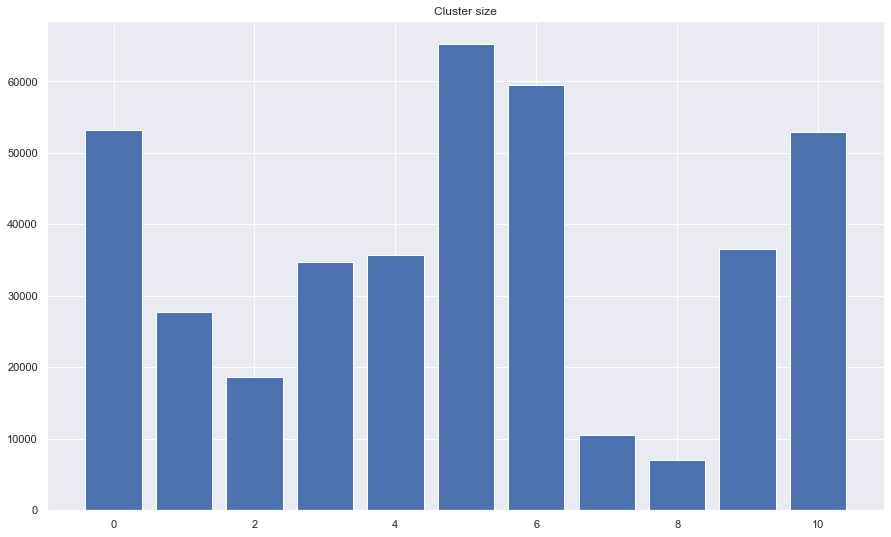

In [9]:
sns.set()
plt.figure(figsize = (15,9))
plt.bar(clust_size['cluster'], clust_size['count_rides'])
plt.title('Cluster size')
plt.show()

We will now create a pivot table where the columns are the regions, the value in the columns is the number of pickups in that region at the given time in the row.

In [10]:
df_crosstab = pd.pivot_table(rides_df, values = 'occupancy', index= 'pickup_time', columns ='cluster', aggfunc = 'sum')

In [11]:
df_crosstab = df_crosstab.replace(np.nan, 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [308]:
region  = 10
ts_one  = pd.Series(df_crosstab[region]).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [309]:
ts_one['weekday'] = ts_one['pickup_time'].dt.day_name()
ts_one['hour_of_day'] = ts_one['pickup_time'].dt.hour
ts_one['minute_of_day'] = ts_one['pickup_time'].dt.minute
ts_one = ts_one.rename(columns = {ts_one.columns[1]: 'zone'})
ts_one['previous_demand'] = ts_one['zone'].shift(1)
#ts_one.loc[ts_one["zone"] > 0, 'zone'] = 1
#ts_one['zone'] = ts_one['zone'].astype('category')
ts_one['weekday'] = ts_one['weekday'].astype('category')
ts_one['previous_demand'] = ts_one['previous_demand'].replace(np.nan, 0)
ts_one['week'] = ts_one['pickup_time'].dt.week

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [310]:
ts_one.head()

,pickup_time,zone,weekday,hour_of_day,minute_of_day,previous_demand,week
0,2008-05-17 12:00:04,0.0,Saturday,12,0,0.0,20
1,2008-05-17 12:00:05,1.0,Saturday,12,0,0.0,20
2,2008-05-17 12:00:07,0.0,Saturday,12,0,1.0,20
3,2008-05-17 12:00:08,0.0,Saturday,12,0,0.0,20
4,2008-05-17 12:00:09,0.0,Saturday,12,0,0.0,20


In [311]:
ts_hour = ts_one.groupby(['weekday','hour_of_day','minute_of_day','week'])['zone'].agg(np.sum).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [312]:
ts_hour.shape, ts_one.shape

((50400, 5), (350332, 7))

In [313]:
ts_hour.loc[ts_hour["zone"] > 0, 'zone'] = 1
ts_hour['zone'] = ts_hour['zone'].astype('category')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


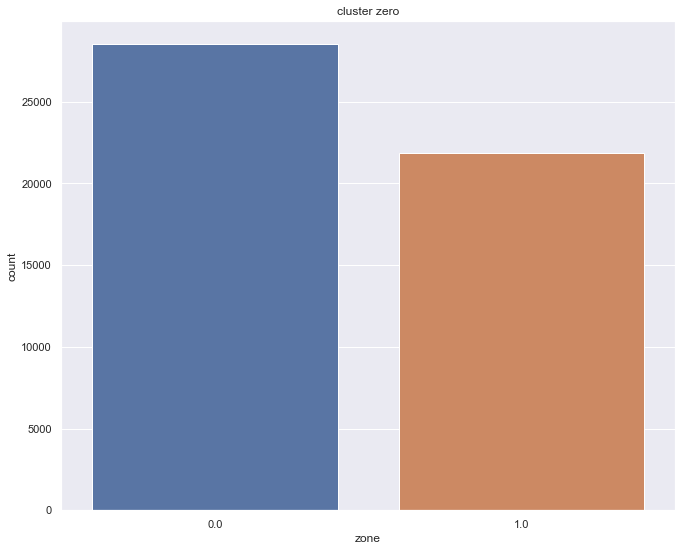

In [314]:
plt.figure(figsize = (11,9))
#plt.rcParams.update({'font.size': 30})
sns.countplot(x = ts_hour['zone'], data = ts_hour)
plt.title('cluster zero')
plt.show()

In [315]:
ts_hour.groupby('zone')['zone'].count()

zone
0.0    28511
1.0    21889
Name: zone, dtype: int64

In [316]:
ts_hour = pd.get_dummies(data = ts_hour, columns = ['weekday'], dtype= int)

In [317]:
ts_hour.dtypes

hour_of_day             int64
minute_of_day           int64
week                    int64
zone                 category
weekday_Friday          int32
weekday_Monday          int32
weekday_Saturday        int32
weekday_Sunday          int32
weekday_Thursday        int32
weekday_Tuesday         int32
weekday_Wednesday       int32
dtype: object

In [318]:
ts_one = ts_one.set_index('pickup_time')
ts_one = ts_one.sort_index()

In [319]:
ts_hour.head()

,hour_of_day,minute_of_day,week,zone,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,0,20,0.0,1,0,0,0,0,0,0
1,0,0,21,0.0,1,0,0,0,0,0,0
2,0,0,22,0.0,1,0,0,0,0,0,0
3,0,0,23,1.0,1,0,0,0,0,0,0
4,0,0,24,0.0,1,0,0,0,0,0,0


<h2 id="Model-Training">Model-Training</h2>

<h3 id="Train-test split">Train-test split</h3>

In [320]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(ts_hour.loc[:, ~ts_hour.columns.isin(['zone'])], ts_hour['zone'], test_size=0.1,  stratify=ts_hour['zone'], random_state = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h3 id="Up-sampling">Up-sampling</h3>

In [321]:
x_train['zone'] = y_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [322]:
minority = x_train[x_train['zone'] == 1]
majority  = x_train[x_train['zone'] == 0]

In [323]:
minority.shape, majority.shape

((19700, 11), (25660, 11))

In [324]:
rides_upsample = resample(minority,
             replace=True,
             n_samples=len(majority),
             random_state=42)

print(rides_upsample.shape)

(25660, 11)


In [325]:
train = pd.concat([rides_upsample, majority])

In [326]:
train = train.sort_index()

In [327]:
train.head()

,hour_of_day,minute_of_day,week,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,zone
0,0,0,20,1,0,0,0,0,0,0,0.0
1,0,0,21,1,0,0,0,0,0,0,0.0
2,0,0,22,1,0,0,0,0,0,0,0.0
3,0,0,23,1,0,0,0,0,0,0,1.0
4,0,0,24,1,0,0,0,0,0,0,0.0


In [328]:
y_train = train['zone']
x_train = train.iloc[:,0:10]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [329]:
x_train.head()

,hour_of_day,minute_of_day,week,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,0,20,1,0,0,0,0,0,0
1,0,0,21,1,0,0,0,0,0,0
2,0,0,22,1,0,0,0,0,0,0
3,0,0,23,1,0,0,0,0,0,0
4,0,0,24,1,0,0,0,0,0,0


In [330]:
y_train.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: zone, dtype: category
Categories (2, float64): [0.0, 1.0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


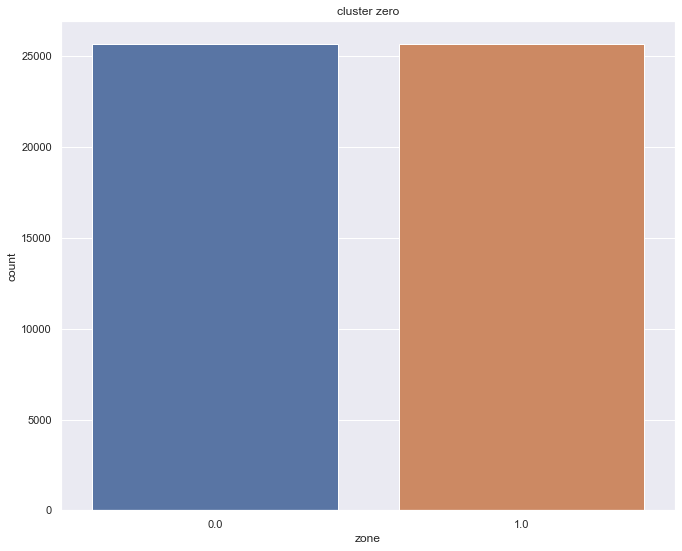

In [331]:
plt.figure(figsize = (11,9))
#plt.rcParams.update({'font.size': 30})
sns.countplot(x = train['zone'], data = train)
plt.title('cluster zero')
plt.show()

<h3 id="logistic regression">logistic regression</h3>

In [332]:
#grid search
kf = KFold(n_splits = 5, shuffle= True, random_state = 123)
log_reg = LogisticRegression()
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l1', 'l2', 'elasticnet'], 'C': loguniform(1e-5, 100) }
log_reg_cv = RandomizedSearchCV(log_reg , param_grid, n_iter=50, scoring='f1', n_jobs=-1, cv=kf, random_state=1)
log_reg_cv.fit(x_train, y_train)
print(log_reg_cv.best_params_, log_reg_cv.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.57581723        nan 0.57575545        nan 0.58516571 0.58222249
 0.61020524 0.60546606        nan        nan        nan        nan
 0.57581723        nan 0.5757332         nan        nan 0.57575545
 0.60564284        nan 0.57587346 0.57328706 0.57575545 0.60840148
 0.57576086        nan 0.57581723        nan 0.57581723 0.575783
 0.61077602        nan 0.57581723        nan 0.57581723 0.57557557
        nan 0.57581723 0.60768825        nan 0.57775931 0.57561443
 0.60800554 0.58781416        na

{'C': 9.544712125688203e-05, 'penalty': 'l2', 'solver': 'newton-cg'} 0.6107760199001052


In [333]:
# Predict probabilities
y_pred_probs = log_reg_cv.predict_proba(x_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [334]:
y_pred  = log_reg_cv.predict_proba(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


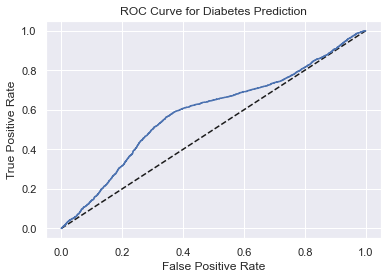

In [335]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.show()

<h3 id="Train-test split">Train-test split</h3>

In [336]:
preds=[ 1 if i<j else 0 for i,j in   y_pred ] 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [337]:
print(roc_auc_score(y_test, preds))

#Calculate the confusion matrix
print(confusion_matrix(y_test, preds))

#Calculate the classification report
print(classification_report(y_test, preds))

0.6033844968601177
[[1720 1131]
 [ 868 1321]]
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63      2851
         1.0       0.54      0.60      0.57      2189

    accuracy                           0.60      5040
   macro avg       0.60      0.60      0.60      5040
weighted avg       0.61      0.60      0.61      5040



<h3 id="Naive-model">Naive model</h3>

Let us simiulate a random guess to determine if our predictions are better than a random guess

In [338]:
n = len(y_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [417]:
region  = 9

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [418]:
ts_one2  = pd.Series(df_crosstab[region]).reset_index()

In [419]:
p = sum(ts_one2[region])/len(ts_one2[region])

In [420]:
p

0.10433531621433383

In [421]:
def perform_bernoulli_trials(n, p):
    n_sucess = 0
    
    for i in range(n):
        rand_number = np.random.random()
        if rand_number < p:
            n_sucess += 1
    return n_sucess

In [422]:
y_pred4 = np.empty(n)
for i in range(n):
    y_pred4[i] = perform_bernoulli_trials(1, p)

In [423]:
print(confusion_matrix(y_test, y_pred4))
print(classification_report(y_test, y_pred4))
print(roc_auc_score(y_test, y_pred4))

[[2565  286]
 [1966  223]]
              precision    recall  f1-score   support

         0.0       0.57      0.90      0.69      2851
         1.0       0.44      0.10      0.17      2189

    accuracy                           0.55      5040
   macro avg       0.50      0.50      0.43      5040
weighted avg       0.51      0.55      0.46      5040

0.5007786613306319
